In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Filters import KALMANFILTER

from Hypotesises import PDA,PDA_Filter

from Trajectory import Trajectory

from scipy.stats import poisson,  norm ,uniform



# track update

# https://www.mathworks.com/matlabcentral/fileexchange/34146-probabilistic-data-association-filters-pdaf-a-tracking-demo

# شبیه سازی در فضای دو بعدی

In [2]:
tr1 = Trajectory('cv','cv')
tr2 = Trajectory("cv",'cv')

B = np.zeros((4,2))
U = np.zeros((2,1))

ground_truth1 = np.array([[0],[0.5],[75],[-1]])
ground_truth2 = np.array([[0],[0.5],[-25],[+1]])

time = 16

for T in range(time-1):

    ground_truth1 = np.append( ground_truth1 ,tr1(ground_truth1[:,[-1]], B,U,T,'normal' ,0,0.2  ),axis=-1)
    ground_truth2 = np.append( ground_truth2 ,tr2(ground_truth2[:,[-1]], B,U,T,'normal' ,0,0.1  ),axis=-1)


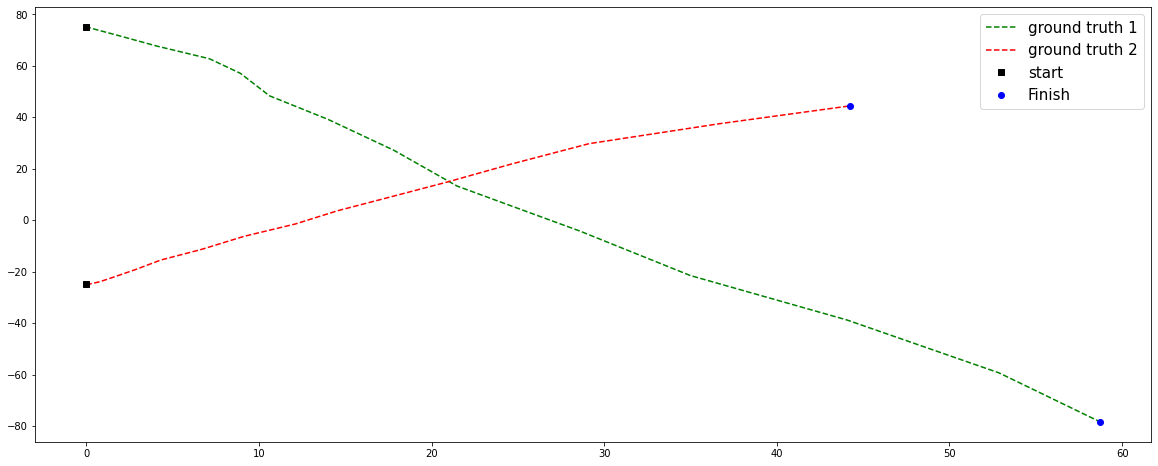

In [3]:
plt.figure(figsize=(20,8))

plt.plot(ground_truth1[0],ground_truth1[2],'--g',label="ground truth 1")
plt.plot(ground_truth2[0],ground_truth2[2],'--r',label="ground truth 2")

plt.plot(ground_truth1[0][0],ground_truth1[2][0],'ks',)
plt.plot(ground_truth2[0][0],ground_truth2[2][0],'ks',label="start")

plt.plot(ground_truth1[0][-1],ground_truth1[2][-1],'bo',)
plt.plot(ground_truth2[0][-1],ground_truth2[2][-1],'bo',label="Finish")

plt.legend(fontsize=15)
plt.show()

In [4]:
def sensor(x,bias,std):
    return np.vstack([ x[0] , x[2] ]) + bias + np.random.normal(loc=0 , scale=std)


C = np.array([[1,0,0,0],[0,0,1,0]])

state_cov1 = np.array([[ 1,   0,  0,  0  ],
                       [ 0,   1,  0  ,0  ],
                       [ 0,   0,  1  ,0  ],
                       [ 0,   0,  0  ,1  ]]) * 0.2**2

state_cov2 = np.array([[ 1, 0, 0, 0 ],
                       [ 0, 1, 0, 0 ],
                       [ 0, 0, 1, 0 ],
                       [ 0, 0, 0, 1 ]]) * 0.1**2

sensor_cov = np.identity(2)

PD = 1
dencity_of_clutters = 0.125

MAX_number_of_clutters = 5

ALL_measurements=[]

for T in range(time):

    pack={'real1':np.empty((2,0)),
          'real2':np.empty((2,0)),
          'clutter':np.empty((2,0)),
          'time_for_clutter':[]
            }

    
    if np.random.choice([ 0 , 1] , p=[1-PD ,PD] ):

        z1 = sensor(ground_truth1[:,[T]],0,1)
    else:
        z1 = np.array([[np.nan],[np.nan]])

    if np.random.choice([ 0 , 1] , p=[1-PD ,PD] ):

        z2 = sensor(ground_truth2[:,[T]],0,1)
    else:
        z2 = np.array([[np.nan],[np.nan]])

    pack['real1'] = np.append(pack['real1'],z1,axis=-1)
    pack['real2'] = np.append(pack['real2'],z2,axis=-1)

    x1 = ground_truth1[0,T]
    y1 = ground_truth1[2,T]

    x2 = ground_truth2[0,T]
    y2 = ground_truth2[2,T]

    std = 20

    r___ = np.random.randint(MAX_number_of_clutters)
    for _ in range(r___):
        
        # cx1 = norm.rvs(loc = x1 ,scale=std)
        # cx2 = norm.rvs(loc = x2 ,scale=std)

        # cy1 = norm.rvs(loc = y1 ,scale=std)
        # cy2 = norm.rvs(loc = y2 ,scale=std)

        cx1 = uniform.rvs( x1 - 10 ,  20)
        cx2 = uniform.rvs( x2 -10 ,  20)

        cy1 = uniform.rvs(y1 - 10 ,  20)
        cy2 = uniform.rvs(y2 - 10 ,  20)

        clutter1 = np.array([[cx1],[cy1]])
        clutter2 = np.array([[cx2],[cy2]])

        CLUTTER = np.hstack([clutter1 ,clutter2])

        pack['clutter'] = np.append(pack['clutter'],CLUTTER,axis=-1)

    pack['time_for_clutter'].extend( [T]* r___*2 )

    if r___ ==0:
        pack['clutter'] = np.append(pack['clutter'],np.array([[np.nan],[np.nan]]),axis=-1)
        pack['time_for_clutter'].extend( [T]* 1)
    

    ALL_measurements.append(pack)
    

ALL_measurements = pd.DataFrame(ALL_measurements)

ALL_measurements
    



,real1,real2,clutter,time_for_clutter
0,"[[0.5340514732301285], [75.53405147323012]]","[[-1.4785913632225014], [-26.478591363222503]]","[[-7.568806045423411, -1.6004643098888494, -8....","[0, 0, 0, 0, 0, 0]"
1,"[[-1.0180055105651011], [74.16255106327476]]","[[-0.521811900065617], [-25.608397267704326]]","[[nan], [nan]]",[1]
2,"[[-0.33799846598365824], [73.30584533368696]]","[[0.46260334246746626], [-24.256116390574427]]","[[-2.7623941771399068, -5.7643312230442625, -8...","[2, 2, 2, 2]"
3,"[[3.2526990925118398], [73.15280926200641]]","[[1.762952465162062], [-21.903446937190658]]","[[-5.437297854673849, 4.750295304622165, -7.85...","[3, 3, 3, 3]"
4,"[[3.0251881839430474], [66.54620076174359]]","[[3.2699629927260196], [-18.81654381316383]]","[[13.634011596765697, 7.964168888958956, 13.85...","[4, 4, 4, 4, 4, 4, 4, 4]"
5,"[[7.63020425908782], [63.21281660341301]]","[[2.578006932602009], [-17.241450999296266]]","[[nan], [nan]]",[5]
6,"[[9.064943950177796], [57.19288979491734]]","[[6.06964586479857], [-11.998141033222558]]","[[nan], [nan]]",[6]
7,"[[12.450960975520807], [50.13088105829186]]","[[8.59141474516429], [-6.841049078553872]]","[[5.6729221065750615, 7.451370613144558, 3.312...","[7, 7, 7, 7, 7, 7, 7, 7]"
8,"[[16.87755484142954], [41.94089969799107]]","[[11.775649920713153], [-1.8398042065641513]]","[[nan], [nan]]",[8]
9,"[[17.778105549636006], [27.095711346783]]","[[14.44479304148968], [3.5160278322752387]]","[[17.674075130243537, 7.039652669113945, 18.50...","[9, 9, 9, 9, 9, 9, 9, 9]"


In [5]:
kalman1 = KALMANFILTER(tr1 ,B ,C ,state_cov1 ,sensor_cov)
kalman2 = KALMANFILTER(tr2 ,B ,C ,state_cov2 ,sensor_cov)


gate1 = 25
gate2 = 25

pda1 = PDA(gate1 , state_cov1 ,sensor_cov, PD , dencity_of_clutters)
pda2 = PDA(gate2 , state_cov2 ,sensor_cov, PD , dencity_of_clutters)


In [6]:
S1 = ground_truth1[:,[0]]
S2 = ground_truth2[:,[0]]

P1 = np.identity(4)
P2 = np.identity(4)


In [7]:
ALL_RESULTS=[]

C = np.array([[1,0,0,0]
            ,[ 0,0,1,0]])

for T in range(time):

    pack={ 
            "track1":np.empty((4,0)),
            "track2":np.empty((4,0)),
            "predict1":np.empty((4,0)),
            "predict2":np.empty((4,0)),
            "valid 1":np.empty((2,0)),
            "valid 2":np.empty((2,0)),
            'time_for_valid1':[],
            'time_for_valid2':[],
            'beta1':[],
            'beta2':[]
    }   
    S1,P1 = kalman1.predict(S1,P1,U,T)
    S2,P2 = kalman2.predict(S2,P2,U,T)

    pack['predict1'] = np.append(pack['predict1'],S1,axis=-1)
    pack['predict2'] = np.append(pack['predict2'],S2,axis=-1)

    Z = np.hstack(ALL_measurements[['real1','real2','clutter']].loc[T])

    Z_hat1 = C @ S1
    Z_hat2 = C @ S2

    S1, P1 , valid1 ,beta1 = pda1.Correcet(S1,P1,C,Z,Z_hat1)
    S2, P2 , valid2, beta2 = pda2.Correcet(S2,P2,C,Z,Z_hat2)
    

    pack['track1'] = np.append(pack['track1'],S1,axis=-1)
    pack['track2'] = np.append(pack['track2'],S2,axis=-1)

    pack['valid 1'] = np.append(pack['valid 1'],valid1,axis=-1)
    pack['valid 2'] = np.append(pack['valid 2'],valid2,axis=-1)

    pack['beta1'].append(beta1.flatten())
    pack['beta2'].append(beta2.flatten())

    pack['time_for_valid1'].extend( [T]* valid1.shape[-1]  )
    pack['time_for_valid2'].extend( [T]* valid2.shape[-1]  )

    ALL_RESULTS.append(pack)

ALL_RESULTS = pd.DataFrame(ALL_RESULTS)
ALL_RESULTS

,track1,track2,predict1,predict2,valid 1,valid 2,time_for_valid1,time_for_valid2,beta1,beta2
0,"[[0.2823350209329942], [0.5], [75.228280804154...","[[0.07911750972310029], [0.5], [-25.6598228712...","[[0.0], [0.5], [75.0], [-1.0]]","[[0.0], [0.5], [-25.0], [1.0]]","[[0.5340514732301285, 2.372347109270617], [75....","[[-1.4785913632225014, -1.6004643098888494, 1....","[0, 0]","[0, 0, 0]","[[0.9133385532756643, 0.027837917312570924]]","[[0.37670643642266854, 1.1089104043073829e-06,..."
1,"[[-0.33831036377932366], [-0.20688295265720846...","[[-0.15599837024604102], [0.13052833488222826]...","[[0.7823350209329942], [0.5], [74.228280804154...","[[0.5791175097231003], [0.5], [-24.65982287120...","[[-1.0180055105651011], [74.16255106327476]]","[[-0.521811900065617], [-25.608397267704326]]",[1],[1],[[1.0]],[[1.0]]
2,"[[-0.4347516526100016], [-0.09530391237827854]...","[[0.49494186141028135], [0.2699413989339473], ...","[[-0.7520762690937406], [-0.20688295265720846]...","[[0.1050582995184155], [0.13052833488222826], ...","[[-0.33799846598365824, -2.7623941771399068, -...","[[0.46260334246746626, -5.7643312230442625, 4....","[2, 2, 2]","[2, 2, 2]","[[0.9230440735730344, 6.893369223287028e-11, 3...","[[0.8870410706337426, 4.0225727281912e-05, 0.0..."
3,"[[0.8784102553336596], [0.21590354756800453], ...","[[1.68488611069558], [0.34179873727905896], [-...","[[-0.7206633897448372], [-0.09530391237827854]...","[[1.3047660582121232], [0.2699413989339473], [...","[[3.2526990925118398, -5.437297854673849, -7.8...","[[1.762952465162062, 4.750295304622165, 7.6730...","[3, 3, 3]","[3, 3, 3]","[[0.7163567074273366, 0.2067116459445629, 8.56...","[[0.9199679467481766, 0.003094094452793814, 1...."
4,"[[3.261316343293711], [0.4156389547693733], [6...","[[3.5991059341697316], [0.4075920602873886], [...","[[1.7420244456056777], [0.21590354756800453], ...","[[3.0520810598118158], [0.34179873727905896], ...","[[3.0251881839430474, 13.634011596765697, 1.02...","[[3.2699629927260196, 7.964168888958956, 5.999...","[4, 4, 4]","[4, 4, 4, 4, 4]","[[0.8683269486789312, 0.05474214828977783, 7.8...","[[0.7425973157498843, 0.00298345330031557, 0.1..."
5,"[[7.430550960858071], [0.6070782148486107], [6...","[[3.0447817786387854], [0.18640778996881208], ...","[[5.339511117140578], [0.4156389547693733], [6...","[[5.6370662356066745], [0.4075920602873886], [...","[[7.63020425908782], [63.21281660341301]]","[[2.578006932602009], [-17.241450999296266]]",[5],[5],[[1.0]],[[1.0]]
6,"[[9.436221243464713], [0.4245218669038493], [5...","[[5.532094110111954], [0.29879512501868816], [...","[[11.073020249949735], [0.6070782148486107], [...","[[4.163228518451658], [0.18640778996881208], [...","[[9.064943950177796], [57.19288979491734]]","[[6.06964586479857], [-11.998141033222558]]",[6],[6],[[1.0]],[[1.0]]
7,"[[12.439572516734069], [0.42753572387466854], ...","[[8.265790219032914], [0.3495958316744221], [-...","[[12.407874311791659], [0.4245218669038493], [...","[[7.623659985242771], [0.29879512501868816], [...","[[12.450960975520807, 5.6729221065750615, 7.20...","[[8.59141474516429, 3.582391823223187, 1.11326...","[7, 7, 7, 7]","[7, 7, 7]","[[0.9142067744366777, 6.634391429446219e-05, 1...","[[0.9230762065877401, 3.254152237458122e-09, 7..."
8,"[[16.75314262337159], [0.5041609749657437], [4...","[[11.608781899696584], [0.3877936322014826], [...","[[15.859858307731418], [0.42753572387466854], ...","[[11.06255687242829], [0.3495958316744221], [-...","[[16.87755484142954], [41.94089969799107]]","[[11.775649920713153], [-1.8398042065641513]]",[8],[8],[[1.0]],[[1.0]]
9,"[[19.605984884051022], [0.36133352262452406], ...","[[14.639581289196242], [0.35707703323325846], ...","[[21.290591398063285], [0.5041609749657437], [...","[[15.098924589509927], [0.3877936322014826], [...","[[17.778105549636006, 17.674075130243537, 18.5...","[[14.44479304148968, 7.039652669113945, 22.741...","[9, 9, 9, 9, 9]","[9, 9, 9]","[[0.003748099133816655, 0.21688959813751793, 0...","[[0.9230766834256289, 4.8919919

In [8]:
clutters=np.hstack(ALL_measurements['clutter'].to_numpy())
real1 =np.hstack(ALL_measurements['real1'].to_numpy())
real2 = np.hstack(ALL_measurements['real2'].to_numpy())
time_for_clutter=np.hstack(ALL_measurements['time_for_clutter'].to_numpy())

track1 = np.hstack(ALL_RESULTS['track1'].to_numpy())
track2 = np.hstack(ALL_RESULTS['track2'].to_numpy())

VALID1 = np.hstack(ALL_RESULTS['valid 1'].to_numpy())
VALID2 = np.hstack(ALL_RESULTS['valid 2'].to_numpy())

time_for_valid1=np.hstack(ALL_RESULTS['time_for_valid1'].to_numpy())
time_for_valid2=np.hstack(ALL_RESULTS['time_for_valid2'].to_numpy())

beta1 = np.hstack(ALL_RESULTS["beta1"].to_numpy())
beta2 = np.hstack(ALL_RESULTS["beta2"].to_numpy())

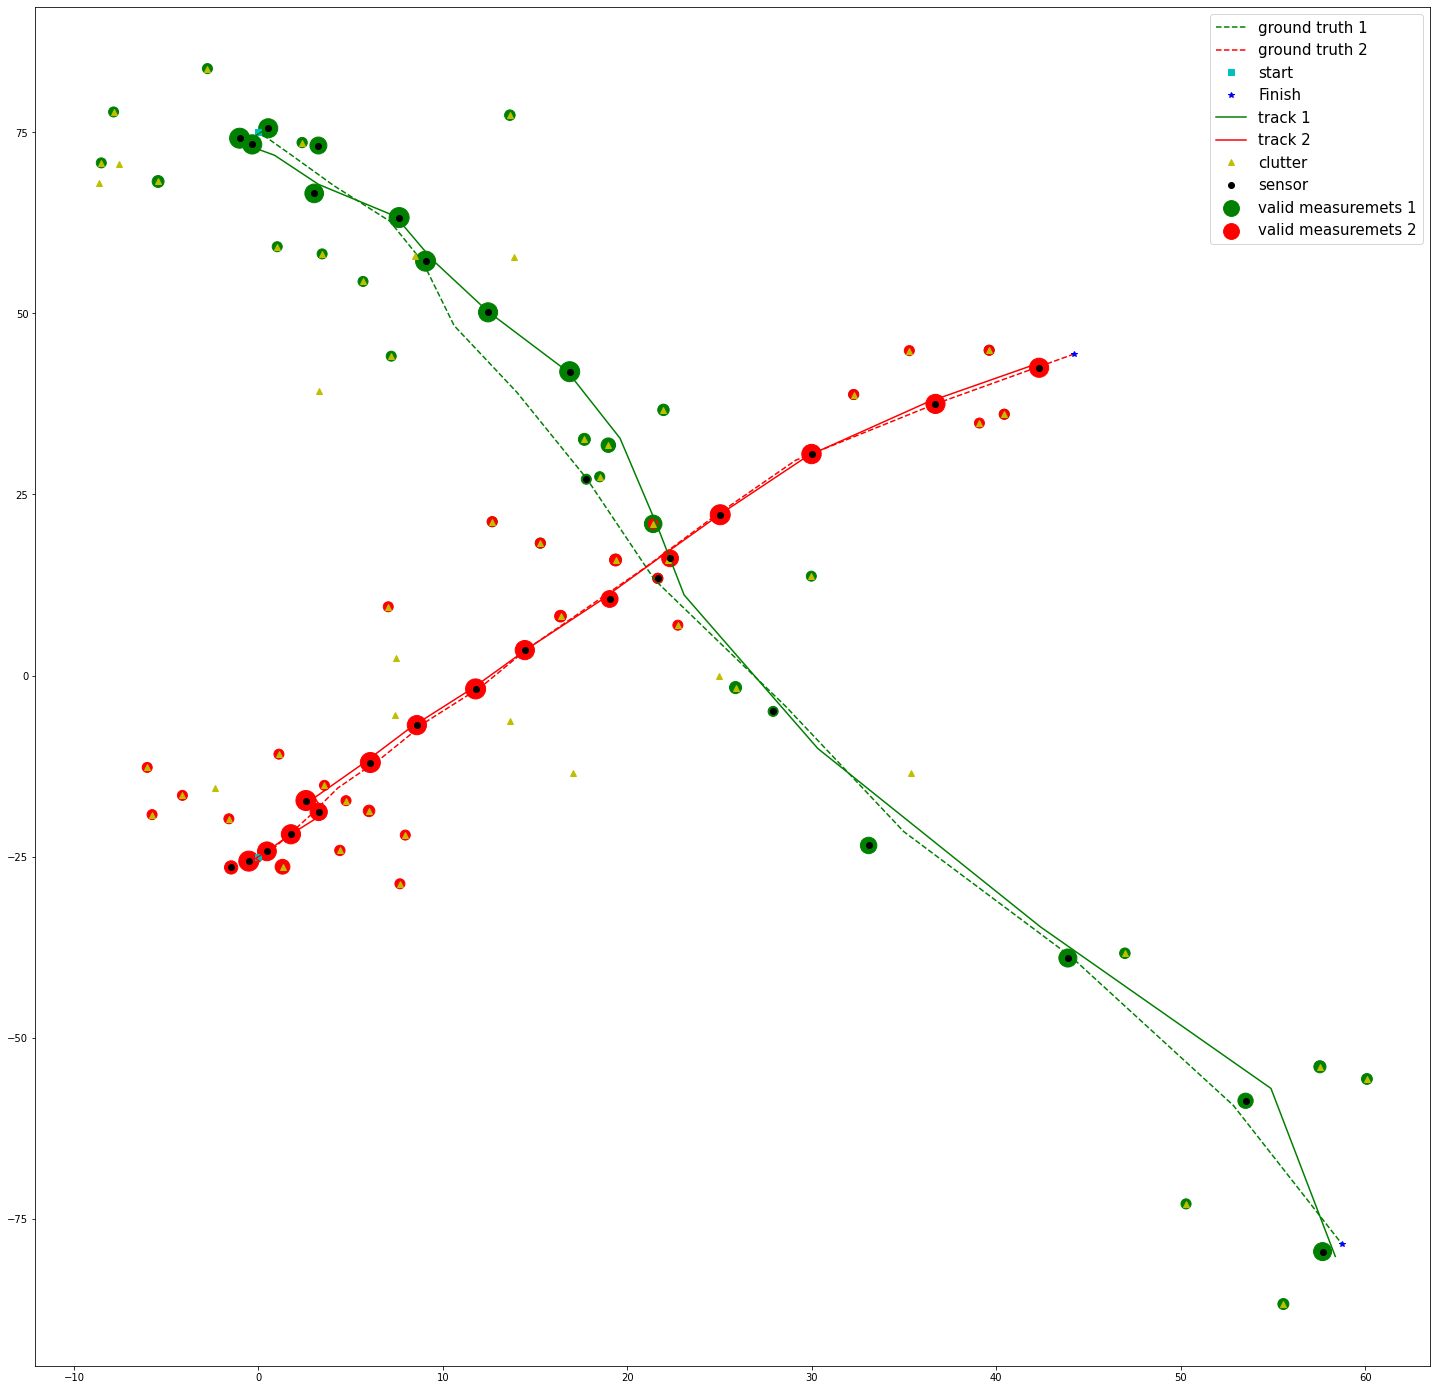

In [9]:
plt.figure(figsize=(25,25))

plt.plot(ground_truth1[0],ground_truth1[2],'--g',label="ground truth 1")
plt.plot(ground_truth2[0],ground_truth2[2],'--r',label="ground truth 2")

plt.plot(ground_truth1[0][0],ground_truth1[2][0],'cs',)
plt.plot(ground_truth2[0][0],ground_truth2[2][0],'cs',label="start")

plt.plot(ground_truth1[0][-1],ground_truth1[2][-1],'b*',)
plt.plot(ground_truth2[0][-1],ground_truth2[2][-1],'b*',label="Finish")


plt.plot(track1[0] , track1[2],'g',label='track 1')
plt.plot(track2[0] , track2[2],'r',label="track 2")


plt.plot(clutters[0],clutters[1],'y^',label='clutter')


plt.scatter(VALID1[0],VALID1[1],s=np.where(beta1>0.5 , beta1*400 , beta1*200+100),label="valid measuremets 1",c='green')
plt.scatter(VALID2[0],VALID2[1],s=np.where(beta2>0.5 , beta2*400 , beta2*200+100) ,label="valid measuremets 2",c='red')

plt.plot(real1[0] ,real1[1],'ko',label="sensor")
plt.plot(real2[0] ,real2[1],'ko')




plt.legend(fontsize=15)
plt.show()

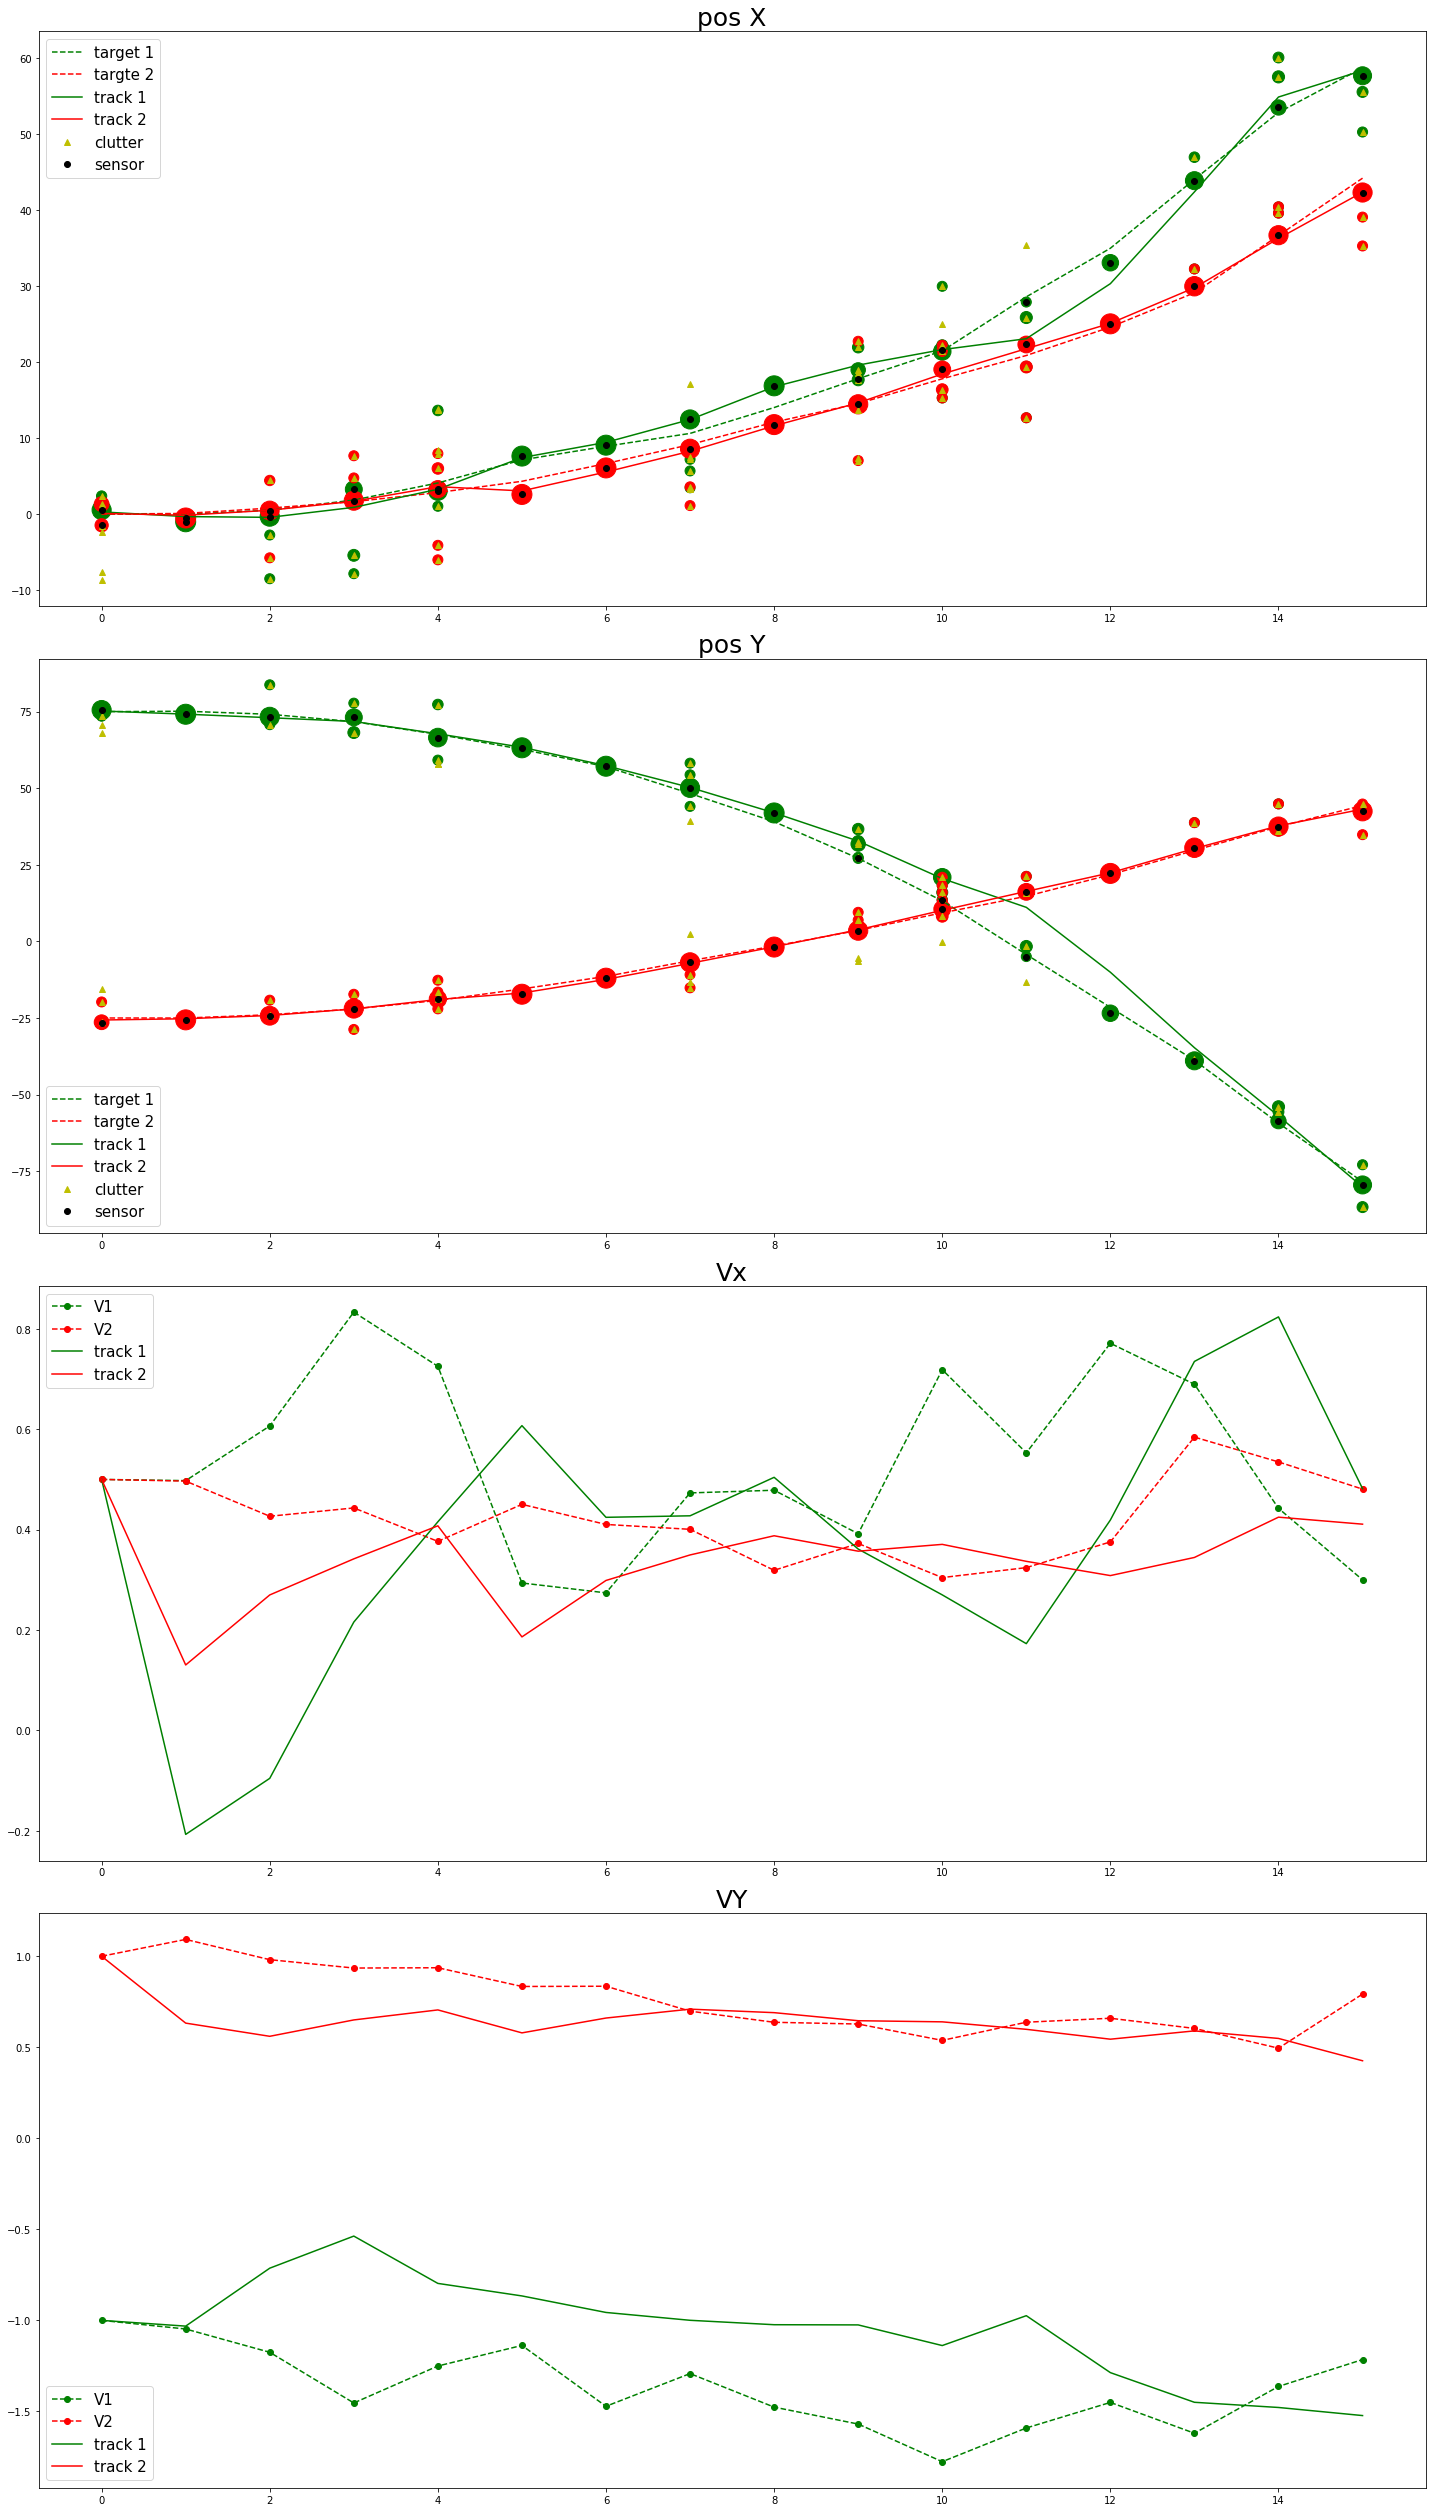

In [10]:
fig , ax  = plt.subplots(4,1,figsize=((20,35)))





ax[0].set_title("pos X",fontsize=25)

ax[0].plot(ground_truth1[0],'g--',label="target 1")
ax[0].plot(ground_truth2[0],'r--',label="targte 2")
ax[0].plot(track1[0] ,'g',label='track 1')
ax[0].plot(track2[0] ,'r',label="track 2")
ax[0].plot(time_for_clutter,clutters[0],'y^',label='clutter')

ax[0].plot(real1[0] ,'ko',label="sensor")
ax[0].plot(real2[0] ,'ko')

ax[0].scatter(time_for_valid1 ,VALID1[0],c='g',s=np.where(beta1>0.5 , beta1*400 , beta1*200+100))
ax[0].scatter(time_for_valid2 ,VALID2[0],c='r',s=np.where(beta2>0.5 , beta2*400 , beta2*200+100))
ax[0].legend(fontsize=15)

ax[0].set_title("pos X",fontsize=25)

# ####



ax[1].plot(ground_truth1[2],'g--',label="target 1")
ax[1].plot(ground_truth2[2],'r--',label="targte 2")
ax[1].plot(track1[2] ,'g',label='track 1')
ax[1].plot(track2[2] ,'r',label="track 2")
ax[1].plot(time_for_clutter,clutters[1],'y^',label='clutter')

ax[1].plot(real1[1] ,'ko',label="sensor")
ax[1].plot(real2[1] ,'ko')

ax[1].scatter(time_for_valid1 ,VALID1[1],c='g',s=np.where(beta1>0.5 , beta1*400 , beta1*200+100))
ax[1].scatter(time_for_valid2 ,VALID2[1],c='r',s=np.where(beta2>0.5 , beta2*400 , beta2*200+100))
ax[1].legend(fontsize=15)

ax[1].set_title("pos Y",fontsize=25)


ax[2].set_title("Vx",fontsize=25)
ax[2].plot(ground_truth1[1],'go--',label="V1")
ax[2].plot(ground_truth2[1],'ro--',label="V2")
ax[2].plot(track1[1] ,'g-',label='track 1')
ax[2].plot(track2[1] ,'r-',label="track 2")
ax[2].legend(fontsize=15)


ax[3].set_title("VY",fontsize=25)
ax[3].plot(ground_truth1[3],'g--o',label="V1")
ax[3].plot(ground_truth2[3],'r--o',label="V2")
ax[3].plot(track1[3] ,'g',label='track 1')
ax[3].plot(track2[3] ,'r',label="track 2")
ax[3].legend(fontsize=15)

plt.tight_layout()
plt.show()

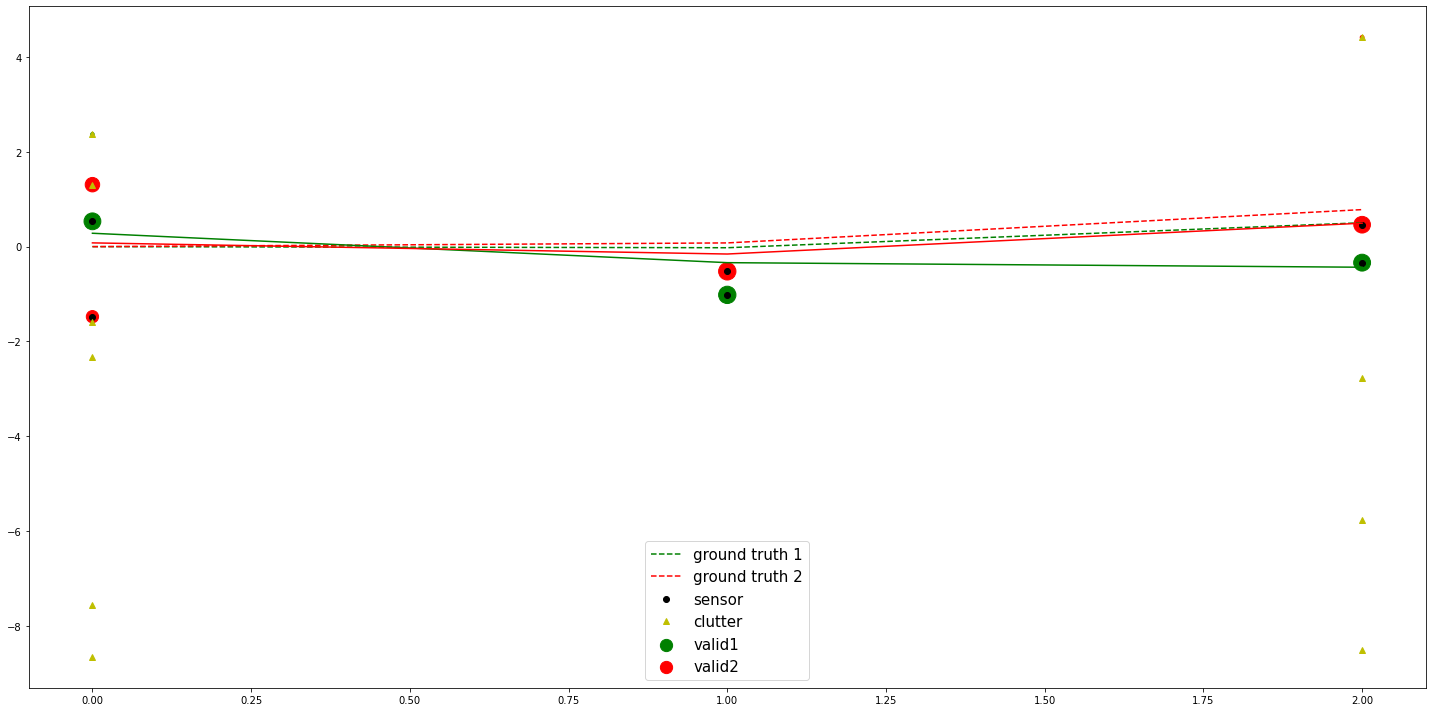

In [11]:
fig , ax  = plt.subplots(1,1,figsize=((20,10)))

time__ = 3

gt1 = ground_truth1[0][range(time__)]
gt2 = ground_truth2[0][range(time__)]
r1 = real1[0][range(time__)]
r2 = real2[0][range(time__)]

tr1__ = track1[0][range(time__)]
tr2__ = track2[0][range(time__)]

tc = time_for_clutter[time_for_clutter<time__]
cl = clutters[0][range(len(tc.flatten()))]

tv1 = time_for_valid1[time_for_valid1<time__]
tv2 = time_for_valid2[time_for_valid2<time__]

val1 = VALID1[0][range(len(tv1.flatten()))]
val2  = VALID2[0][range(len(tv2.flatten()))]

b1 = beta1[0][range(val1.size)]
b2 = beta2[0][range(val2.size)]

b1 = np.where(b1<=0.5 , b1*400 , b1*200+100)
b2 = np.where(b2<=0.5 , b2*400 , b2*200 + 100)
ax.plot(range(time__),gt1,'g--',label='ground truth 1')
ax.plot(range(time__),gt2,'r--',label='ground truth 2')
ax.plot(range(time__),r1,'ko',label='sensor')
ax.plot(range(time__),r2,'ko')
ax.plot(range(time__),tr1__,'g')
ax.plot(range(time__) , tr2__ ,'r')
ax.plot(tc,cl,'^y',label="clutter")
ax.scatter(tv1 , val1 ,s= b1 , c='g',label="valid1")
ax.scatter(tv2 , val2 ,s= b2 ,c='r', label="valid2")
ax.legend(fontsize=15)


plt.tight_layout()
plt.show()

In [12]:
b2

array([1.50682575e+02, 4.43564162e-04, 2.09273876e+02, 3.00000000e+02,
       2.77408214e+02, 1.60902909e-02, 1.43982507e+01])

In [13]:
val1

array([ 0.53405147,  2.37234711, -1.01800551, -0.33799847, -2.76239418,
       -8.51756361])